# Copying patterns analysis

In [1]:
import collections

import sc2ts
import numpy as np
import pandas as pd
import tskit
import numpy as np
import tskit_arg_visualizer as argviz  # Install latest within a notebook cell using `!pip install git+https://github.com/kitchensjn/tskit_arg_visualizer`

import nb_utils

from IPython.display import HTML
HTML('<style type="text/css">.progress .progress-bar::after{content:"🦠";display:block;text-align:right;margin-top:-2px;}'
     '.progress .progress-bar {background-color: #BBBBFF}</style>')

In [2]:
# Get the Viridian ARG
ts = nb_utils.load()
ti = sc2ts.TreeInfo(ts)
ds = nb_utils.load_dataset()
df = pd.read_csv("../data/recombinants.csv")

Loaded 731.5 megabyte SARS-CoV2 genealogy of 2482157 strains (345 trees, 1922947 mutations over 29904.0 basepairs). Last collection date is 2023-02-20


Counting descendants :   0%|          | 0/2689054 [00:00<?, ?it/s]

Indexing metadata    :   0%|          | 0/2689054 [00:00<?, ?it/s]

Classifying mutations:   0%|          | 0/1922947 [00:00<?, ?it/s]

## Detect problematic patterns

Identify the number of sites supporting each edge of a recombination node, where a "site" can consist of runs of adjacent or near-adjacent positions where the potential parents differ, and the child matches one of them

In [3]:
import numpy as np
import nb_utils
import sc2ts
import collections

from tqdm.auto import tqdm

def recombinant_supporting_locations(ts, adjacent_distance=3):
    # return a dictionary maping each recombination node to
    # the number of "supporting sites" for each edge above that node
    # where 
    sorted_edges = {}
    nodes_used = []
    run_positions = collections.defaultdict(list)
    for u in np.where(ts.nodes_flags & sc2ts.NODE_IS_RECOMBINANT)[0]:
        edges = np.where(ts.edges_child == u)[0]
        sorted_edges[u] = edges[np.argsort(ts.edges_left[edges])]
        nodes_used.append(u)
        nodes_used += list(ts.edges_parent[edges])
    nodes_used, inverse = np.unique(nodes_used, return_inverse=True)
    node_map = {index: id_ for id_, index in zip(inverse, nodes_used[inverse])}
    
    last_pos = {u: np.full(len(v), -np.inf) for u, v in sorted_edges.items()}
    last_parent = {u: np.full(len(v), -1) for u, v in sorted_edges.items()}
    supporting_location_count = {u: np.full(len(v), 0) for u, v in sorted_edges.items()}
    edge_index = {u: 0 for u in sorted_edges.keys()}
    
    sts = ts.simplify(nodes_used)
    for v in tqdm(sts.variants(), total=sts.num_sites):
        genotypes = v.genotypes
        pos = v.site.position
        for re_node, edge_list in sorted_edges.items():
            parents = ts.edges_parent[edge_list]
            parent_genos = [genotypes[node_map[p]] for p in parents]
            if np.all(np.diff(parent_genos) == 0):
                # irrelevant site, as parents are all identical genotype
                continue
            last_position = last_pos[re_node]
            re_geno = genotypes[node_map[re_node]]
            assert re_geno >= 0
    
            # pick the correct edge for this re node advancing along the sequence if necessary
            edge = ts.edge(edge_list[edge_index[re_node]])
            while edge.right <= pos:
                edge_index[re_node] += 1
                edge = ts.edge(edge_list[edge_index[re_node]])
            idx = edge_index[re_node]
            assert edge.child == re_node
            parent_geno = genotypes[node_map[edge.parent]]
            if pos - last_position[idx] > adjacent_distance:
                if re_geno == parent_geno:
                    supporting_location_count[re_node][idx] += 1
                elif re_geno in parent_genos:
                    supporting_location_count[re_node][idx] -= 1
                else:
                    pass  # this is a de-novo mutation
            else:
                run_positions[re_node].append(int(last_position[idx]))
                if last_parent[re_node][idx] != edge.parent:
                    raise ValueError("conflicting parents within 4 bp")
            last_position[idx] = pos
            last_parent[re_node][idx] = edge.parent
    return supporting_location_count, run_positions

supporting_location_count, run_positions = recombinant_supporting_locations(ts)
good = {u for u, support in supporting_location_count.items() if not (np.any(support < 4))}
bad = {}

rdf = df.set_index("recombinant")
for re_node, support in supporting_location_count.items():
    if re_node not in good:
        bad[re_node] = rdf.loc[re_node].descendants
bad = {k: bad[k] for k in sorted(bad.keys(), key=lambda x: -bad[x])}
print(
    f"{len(bad)} bad recombinants out of {len(df)}.",
    f"The one with max descendants is {list(bad.keys())[0]} with {list(bad.values())[0]} descendants"
)

  0%|          | 0/4528 [00:00<?, ?it/s]

543 bad recombinants out of 929. The one with max descendants is 1030562 with 166285 descendants


## Commonly-found runs

These are the first positions in runs of "supporting locations": i.e. adjacent or near-adjacent sites which differentiate between parents of the 929 recombination nodes.
These represent both true sites (often deletions), but also could be accidentally left-in primers, or other bioinformatic errors.

commonly adjacent positions [(22029, 363), (22031, 363), (22032, 363), (22033, 363), (22030, 362), (22027, 334), (22195, 145), (22194, 140), (27382, 135), (21767, 132), (21768, 132), (21769, 132), (22197, 98), (22202, 97), (22196, 93), (11292, 57), (11293, 57), (11294, 57), (11295, 57), (22026, 55), (6513, 53), (6514, 53), (21994, 53), (21988, 52), (21989, 52), (11283, 51), (11284, 51), (11285, 51), (11286, 51), (21633, 42), (21634, 42), (21635, 42), (21636, 42), (21637, 42), (21638, 42), (21639, 42), (21640, 42), (27881, 40), (27882, 40), (28881, 31)]


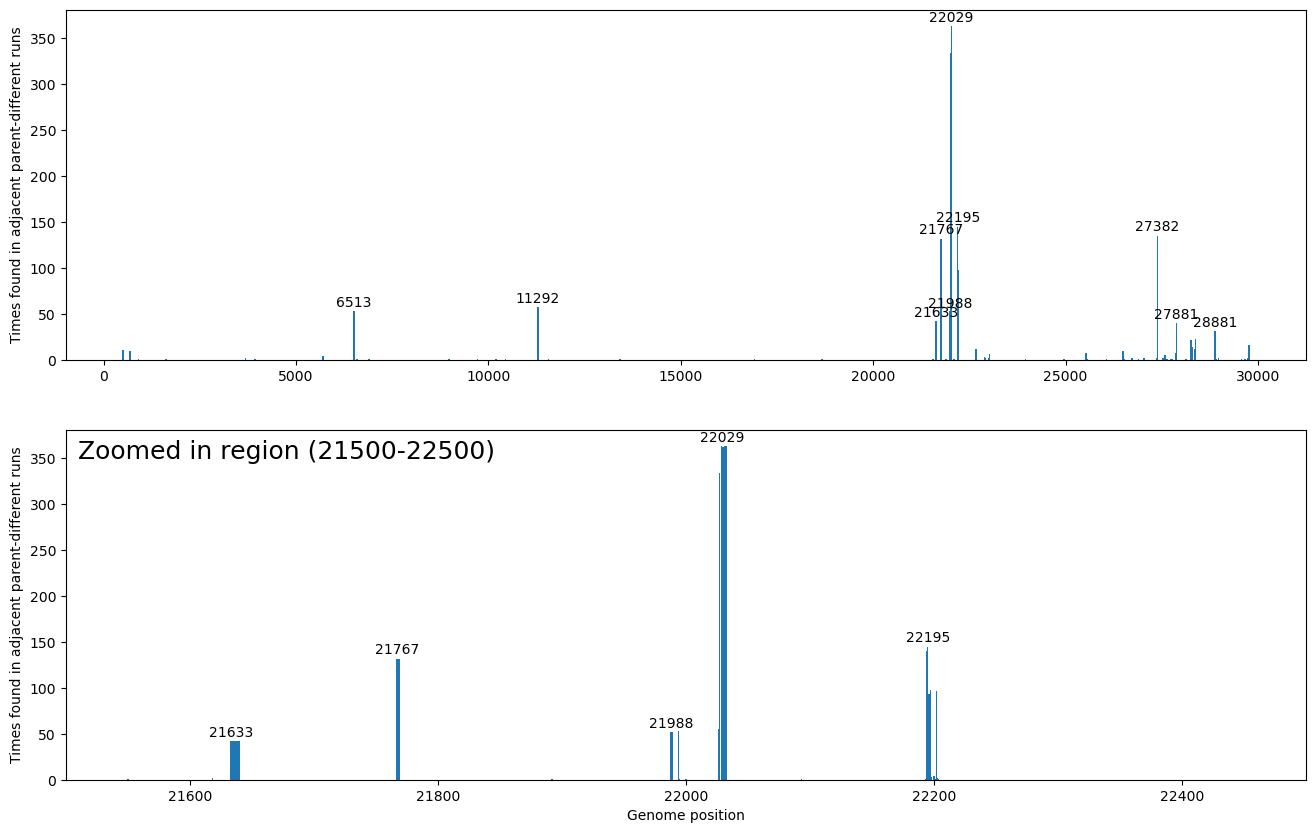

In [4]:
from matplotlib import pyplot as plt

run_position_counts = collections.Counter([x for positions in run_positions.values() for x in positions])
print("commonly adjacent positions", run_position_counts.most_common(40))

positions = [22029, 22195, 27382, 21767, 11292, 6513, 21988, 21633, 27881, 28881]
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
for ax, xlim, width in zip(axes, [(0, ts.sequence_length), (21500, 22500)], (40, 1)):
    ax.bar(list(run_position_counts.keys()), list(run_position_counts.values()), width=width)
    plt.xlim(xlim)
    ax.set_ylabel("Times found in adjacent parent-different runs")
    for p in positions:
        if p > xlim[0] and p < xlim[1]:
            ax.text(p, run_position_counts[p] + 5, p, ha="center")
ax.text(xlim[0]+10, 350, f"Zoomed in region ({xlim[0]}-{xlim[1]})", size=18);
ax.set_xlabel("Genome position");

## Suggested "good" recombinant copying patterns

We can exclude recombinants that have fewer than 4 "supporting locations" on any edge. 

386 'good' recombinants, whith the following supported locations [(21767, 118), (21768, 118), (21769, 118), (27382, 117), (22195, 57), (22194, 53), (11292, 52), (11293, 52), (11294, 52), (11295, 52)]
Common deletions at the following locations: (21769, 703)
(21770, 696)
(21768, 680)
(21767, 662)
(21995, 644)
(21990, 519)
(6515, 517)
(6513, 473)
(6514, 466)
(22034, 410)
(22032, 390)
(22033, 387)
(21988, 383)
(21994, 379)
(22029, 377)
(21989, 376)
(22030, 373)
(22194, 368)
(22031, 359)
(22195, 331)


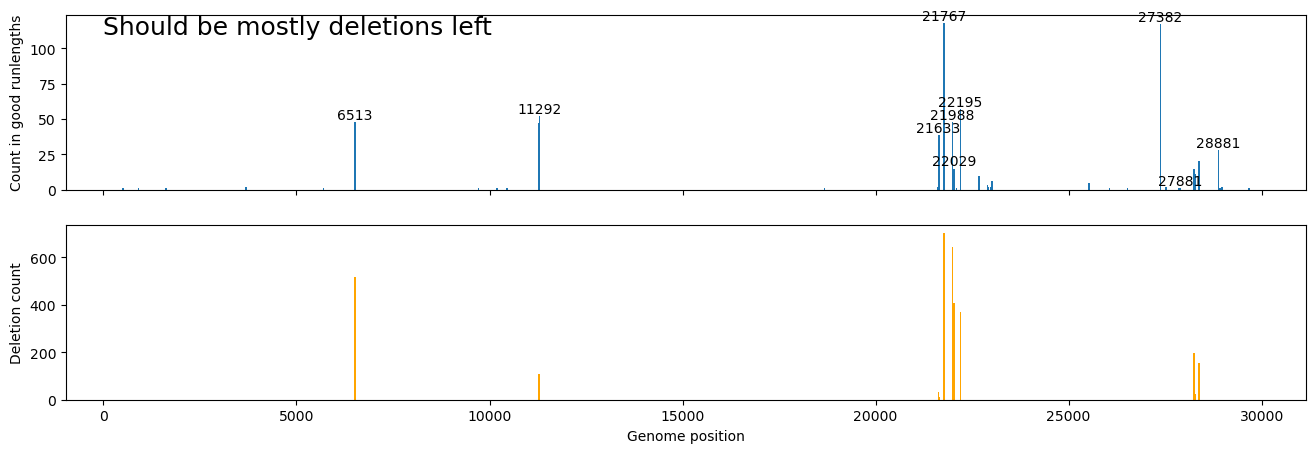

In [5]:
good_run_position_counts = collections.Counter([
    x
    for re_node, positions in run_positions.items() for x in positions
    if re_node in good
])

fig, axes = plt.subplots(2, 1, figsize=(16, 5), sharex=True)
axes[0].bar(list(good_run_position_counts.keys()), list(good_run_position_counts.values()), width=40)
axes[0].set_ylabel("Count in good runlengths")
for p in positions:
    axes[0].text(p, good_run_position_counts[p] + 2, p, ha="center")
axes[0].text(0, 110, "Should be mostly deletions left", size=18);

ctr = collections.Counter([int(s.position) for s in ts.sites() for m in s.mutations if m.derived_state == "-"])
axes[1].bar(ctr.keys(), ctr.values(), width=40, color="orange")
axes[1].set_ylabel("Deletion count")
axes[1].set_xlabel("Genome position")

print(len(good), "'good' recombinants, whith the following supported locations", good_run_position_counts.most_common(10))
print("Common deletions at the following locations:", "\n".join([str(c) for c in ctr.most_common(20)]))

# Dict to save the copying patterns, as these take some time to plot
patterns = {u: None for u in supporting_location_count.keys()}

## Plot the suggested "good" recombinant copying patterns

Label with 1 to 929 regardless of "good" or "bad" status, for ease of discussion.

In [6]:
from IPython.display import HTML

use_stylesheet=True
for i, u in enumerate(supporting_location_count.keys()):
    if u not in good:
        continue
    children = [ts.node(i).metadata.get("Imputed_Viridian_pangolin", "") for i in ts.edges_child[ts.edges_parent == u]]
    labels = [c for c in children if c.startswith("X")] + [c for c in children if c != ""]
    if u == 200039:
        labels[0] = "Delta"
    d = ti.nodes_max_descendant_samples[u]
    causal = df[df.recombinant == u].sample_id.values
    html = ti.copying_table(u, show_bases=True, hide_extra_rows=False, child_label=labels[0], exclude_stylesheet=use_stylesheet)
    patterns[u] = html
    display(HTML(
        f"<div style='display:table-cell; vertical-align: top; font-size: 16pt'>{i})&nbsp;</div>" +
        "<div style='display:table-cell'>" +
        html +
        "</div><div style='display:table-cell; vertical-align: middle;'>" +
        f"&nbsp;&nbsp;(Node {u}: {d} sample descendant{'s' if d > 1 else ''}, " +
        f"causal: {causal})<br>&nbsp;</div>"  # bit of a hack with the &nbsp; here
    ))
    use_stylesheet=False


## Plot the suggested "bad" recombinant copying patterns

In [7]:
use_stylesheet=True
for i, u in enumerate(supporting_location_count.keys()):
    if u in good:
        continue
    children = [ts.node(i).metadata.get("Imputed_Viridian_pangolin", "") for i in ts.edges_child[ts.edges_parent == u]]
    labels = [c for c in children if c.startswith("X")] + [c for c in children if c != ""]
    if u == 200039:
        labels[0] = "Delta"
    d = ti.nodes_max_descendant_samples[u]
    causal = df[df.recombinant == u].sample_id.values
    html = ti.copying_table(u, show_bases=True, hide_extra_rows=False, child_label=labels[0], exclude_stylesheet=use_stylesheet)
    patterns[u] = html
    display(HTML(
        f"<div style='display:table-cell; vertical-align: top; font-size: 16pt'>{i})&nbsp;</div>" +
        "<div style='display:table-cell'>" +
        html +
        "</div><div style='display:table-cell; vertical-align: middle;'>" +
        f"&nbsp;&nbsp;(Node {u}: {d} sample descendant{'s' if d > 1 else ''}, " +
        f"causal: {causal})<br>&nbsp;</div>"  # bit of a hack with the &nbsp; here
    ))
    use_stylesheet=False


## Add to the recombinants CSV file, if not already there

(repeat elements of the code above, so it can be easily copied and pasted: requires `recombinant_supporting_locations` function)

In [8]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import sc2ts
from tqdm.auto import tqdm
import tskit

import nb_utils

ts = nb_utils.load()
ti = sc2ts.TreeInfo(ts)
filename = "../data/recombinants.csv"
df = pd.read_csv(filename)

# Redo the count, so that code in cell is independent
supporting_loci_count, run_positions = recombinant_supporting_locations(ts)
new_cols = np.array([
    [u, *support]
    for u, support in supporting_loci_count.items()
]).T

new_cols = np.vstack((new_cols,
    [np.minimum(new_cols[1, :], new_cols[2, :]) >= 4],
))

new_df = df.set_index("recombinant")
colnames = {  # column in new_cols => name in new df
    1: ("net_min_supporting_loci_lft", int),
    2: ("net_min_supporting_loci_rgt", int),
    3: ("net_min_supporting_loci_lft_rgt_ge_4", bool),
}
for use, (colname, dtype) in colnames.items():
    if colname not in df.columns:
        new_df.loc[new_cols[0, :], colname] = new_cols[use, :]
        print(f"Overwriting exising {filename} to add column '{colname}'")
        df[colname] = new_df[colname].values
        df[colname] = df[colname].astype(dtype)
        df.to_csv(filename, index=False)

Loaded 731.5 megabyte SARS-CoV2 genealogy of 2482157 strains (345 trees, 1922947 mutations over 29904.0 basepairs). Last collection date is 2023-02-20


Counting descendants :   0%|          | 0/2689054 [00:00<?, ?it/s]

Indexing metadata    :   0%|          | 0/2689054 [00:00<?, ?it/s]

Classifying mutations:   0%|          | 0/1922947 [00:00<?, ?it/s]

  0%|          | 0/4528 [00:00<?, ?it/s]